# Project 1


In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from itertools import imap
except ImportError:
    # Python 3...
    imap=map
np.random.seed(42)
random.seed(42)

In [ ]:
PATH =  'Project1-Classification.csv'

# Getting familiar with the dataset

In [ ]:
def count_alphanum(s):
  count = sum(imap(str.isdigit, s)) + sum(imap(str.isalpha, s))
  return count
def plot_histogram(df,feature,flag=False, bins=10):
  plt.figure()
  #df.hist(xlabelsize = 10, bins=bins)
  sns.histplot(df,bins=bins)  
  if flag:
    plt.xlabel('class')
    plt.xticks(rotation=90)
    
  else:
    plt.xlabel('count')
  plt.ylabel('frequency')
  plt.title('Histogram for feature : '+feature)

In [ ]:
df = pd.read_csv(PATH)
#display(df)
print('dataframe shape: ',df.shape)

dataframe shape:  (3150, 8)


QUESTION 1: Provide answers to the following questions:<br>
* **Overview:** How many rows (samples) and columns (features) are present 
in the dataset?<br>
There are 3150 rows (samples) and 8 columns (features) in this dataset.<br>
* **Histograms:** Plot 3 histograms on : (a) The total number of alpha-numeric characters per
data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;


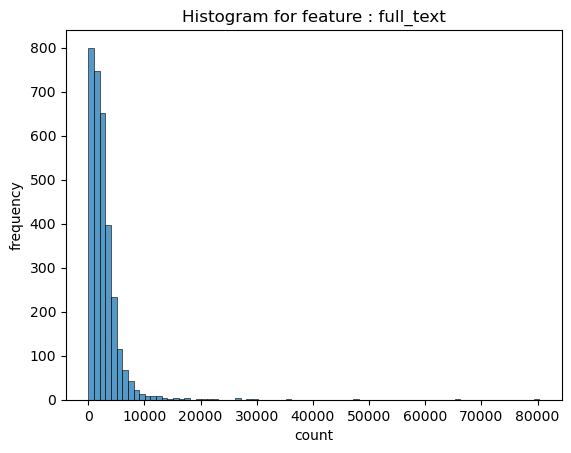

In [ ]:
count_fulltext = df['full_text'].apply(count_alphanum)
# In order to select an appropriate number of bins, 
#I decided to set the sensitivity to 1000 and by dividing the largest count by 1000 I got 80 bins.
bins = max(count_fulltext)//1000
plot_histogram(count_fulltext,'full_text',False,bins)


(b) The column leaf label – class on the x-axis; 

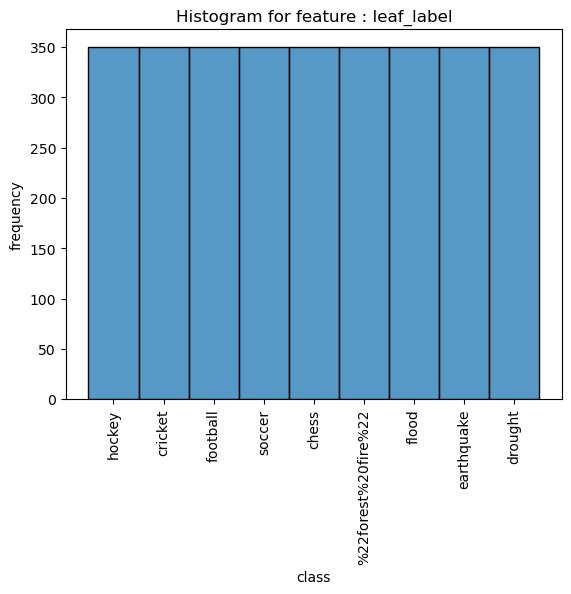

In [ ]:
plot_histogram(df['leaf_label'],'leaf_label',True,9)


(c) The column root label – class on the
x-axis.

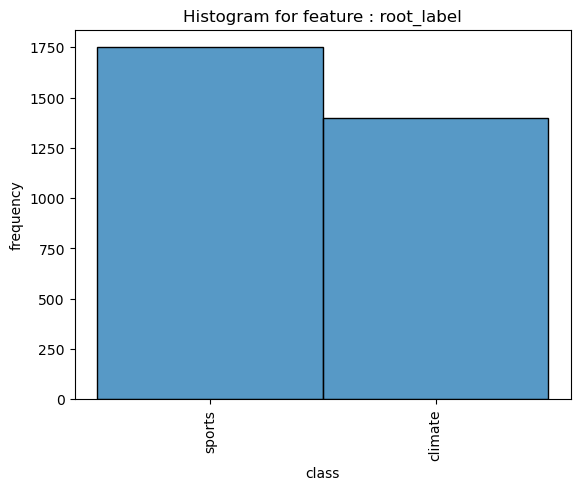

In [ ]:
plot_histogram(df['root_label'],'root_label',True,2)


* **Interpret Plots:** Provide qualitative interpretations of the histograms.<br>
For each of the histograms the qualitative interpretations are as follows: <br>
(a) The majority of full_text data samples have less than 10,000 alphanumerical characters in them. Although some samples have as many as 80,000 alphanumerical characters, these samples are very few. <br>
(b) The dataset is *balanced* with respect to 'leaf_label'. All 9 possible classes have equal number of samples in them. <br>
(c) The dataset is a bit *unbalanced* with respect to 'root_label'. I.e. there are more samples that are labeled as 'sport' than 'climate'. This could cause a bias in the next steps.

# Binary Classification

## Splitting the entire dataset into training and testing data

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

In [ ]:
print('number of train samples: ',train.shape[0])
print('number of test samples: ',test.shape[0])

number of train samples:  2520
number of test samples:  630


QUESTION 2: Report the number of training and testing samples.<br>
There are 2520 train samples and 630 test samples.

## Feature Extraction

In [ ]:
import re
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter) 
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

QUESTION 3: Use the following specs to extract features from the textual data:
* Before doing anything, please clean each data sample using the code block provided above.
This function helps remove many but not all HTML artefacts from the crawler’s output. You
can also build your own cleaning module if you find this function to be ineffective.
* Use the “english” stopwords of the CountVectorizer
* Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
* Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
* Use min df=3

In [ ]:
#clean text with given code
X_tr = train['full_text'].apply(clean)
X_ts = test['full_text'].apply(clean)


#read labels and convert them to binary
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y_tr = encoder.fit_transform(train['root_label'])
Y_ts = encoder.transform(test['root_label'])
print('Binary labels are assigned as follows: ')
print('0: ',encoder.inverse_transform([0]))
print('1: ',encoder.inverse_transform([1]))


import nltk
# We need to download the following to avoid errors.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag

# NOTE: I wrote the next two functions using guidelines on Stackoverflow.
def remove_digit(text):
    #this function helps us remove digits 
    text = text.lower() #converts to lower case
    text = re.sub(r'\d+', '', text) #helps remove one or more (+) digits (\d) 
    return text


def lemm(text):
    stop = stopwords.words('english')
    #this will help us implement lemmatization
    text = ''.join([ch for ch in text if ch not in string.punctuation]) #removes punctuations and separates words with spaces ('')
    tokens = nltk.word_tokenize(text) #tokenizes words
    lemmatizer = WordNetLemmatizer() #we will use this to lemmatize the tokens.
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop]

def stem(text):
    stop = stopwords.words('english')
    #this will help us implement stemming (to be used in GridSearch question)
    text = ''.join([ch for ch in text if ch not in string.punctuation]) #removes punctuations and separates words with spaces ('')
    tokens = nltk.word_tokenize(text) #tokenizes words
    stemmer = PorterStemmer() #we will use this to stem the tokens.
    return [stemmer.stem(token) for token in tokens if token not in stop]


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# Based on the given guidelines in project description, we create the following pipeline:
pipe = Pipeline([('count', CountVectorizer(min_df=3,stop_words={'english'}, #count words by:
                        preprocessor=remove_digit,tokenizer=lemm)), #removing digits and lemmatizing
                        ('tfid', TfidfTransformer())]) #finally apply TF-IDF
X_tr_new = pipe.fit_transform(X_tr).toarray()
X_ts_new = pipe.transform(X_ts).toarray()


#vectorizer = CountVectorizer(min_df=3,stop_words={'english'},preprocessor=preprocess_text,tokenizer=tokenize)
#X_tr = vectorizer.fit_transform(X_tr)
#X_ts = vectorizer.transform(X_ts)

Binary labels are assigned as follows: 
0:  ['climate']
1:  ['sports']


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/golaraahmadiazar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/golaraahmadiazar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/golaraahmadiazar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/golaraahmadiazar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print('train td-idf matrix shape: ',X_tr_new.shape)
print('test td-idf matrix shape: ',X_ts_new.shape)

train td-idf matrix shape:  (2520, 15828)
test td-idf matrix shape:  (630, 15828)


Please answer the following questions:
* What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size? <br>
 *The problem with stemming is that sometimes by removing prefixes and suffixes, the remaining stem doesn't make sense. Also, we might get two different stems for what is supposed to be one stem. For example: if we use stemming for words "studied" and "studying", we will end up with stems "studi" and "study", but only one of them is correct. This problem can be solved by a lemmatization algorithm to lemmatize words correctly. So in general, one lemma might correspond to multiple stems. It is expected that using lemmatization can result in a more informative dictionary rather than stemming.*<br>
 *The problem with lemmatization is that it requires deep linguistic analysis to build. So an advantage of stemming to lemmatization is that stemming is simpler to build.* 

* min_df means minimum document frequency. How does varying min df change the TF-IDF matrix? <br>
 *We use min_df to remove terms that appear too infrequently. Terms that occur rarely can sometimes be considered as noise and removing them helps with model performance. Increasing min_df reduces the number of columns in the matrix. For example, for min_df=3, there are 15828 columns in the matrix whereas for min_df=5, there are 10942.*

* Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure. <br>

 *As can be seen in the code, the punctuations are first removed along with digits. The sentence is tokenized and we lemmatize words that are not in the stop-words (I learned this by experiment, otherwise some meaningless terms remain).*

* Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×10^3. <br>
  *train td-idf matrix shape:  (2520, 15828)*<br>
  *test td-idf matrix shape:  (630, 15828)*<br>
This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.

## Dimensionality Reduction
QUESTION 4: Reduce the dimensionality of the data using the methods above:

### Latent Semantic Indexing (LSI)
* Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000]
for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest? <br>
  *The variance ratio is increasing with respect to k. As can be seen in the plot, the rate of this increase is decreasing, basically meaning that the principal components corresponding to the smallest singular values are not as effective as the principal components corresponding to larger singular values. The concavity suggests that we can ignore least significant principal components without losing much information.*

In [ ]:
from numpy.linalg import svd
U, S, V_h = np.linalg.svd(X_tr_new, full_matrices=False)
V = V_h.T

Text(0.5, 1.0, 'scatter plot of variance ratio vs k for LSI')

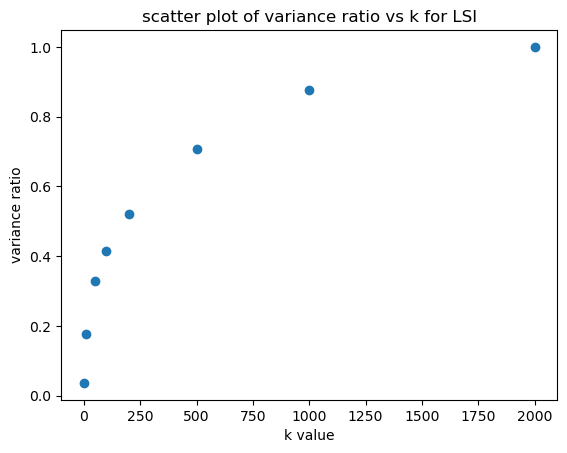

In [ ]:
denominator = np.sum(S**2)

ratio = []
K = [1, 10, 50, 100, 200, 500, 1000, 2000]
for k in K:
  numerator = np.sum(S[:k]**2)
  ratio.append(numerator/denominator)
plt.figure()
plt.scatter(K,ratio)
plt.xlabel('k value')
plt.ylabel('variance ratio')
plt.title('scatter plot of variance ratio vs k for LSI')


**NOTE:** In order for the residual MSEs to be comparabel between train and test data, I have normalized them by the number of samples in each set.

In [ ]:
k = 50
V_k = V[:,:k]
X_tr_svd = X_tr_new@V_k
X_ts_svd = X_ts_new@V_k

print('train data shape after LSI: ',X_tr_svd.shape)
print('test data shape after LSI: ',X_ts_svd.shape)

LSI_rMSE = np.linalg.norm(X_tr_new - U[:,:k]@np.diag(S[:k])@(V_k.T), ord='fro')
print('The normalized residual MSE for train LSI is:',LSI_rMSE/X_tr_new.shape[0])
LSI_rMSE = np.linalg.norm(X_ts_new - X_ts_svd@(V_k.T), ord='fro')
print('The normalized residual MSE for test LSI is:',LSI_rMSE/X_ts_new.shape[0])

train data shape after LSI:  (2520, 50)
test data shape after LSI:  (630, 50)
The normalized residual MSE for train LSI is: 0.01631504906088195
The normalized residual MSE for test LSI is: 0.03370740426654134


### Non-negative Matrix Factorization (NMF)

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=k, init='nndsvd')
W_train = nmf.fit_transform(X_tr_new)
H = nmf.components_
W_test = nmf.transform(X_ts_new)

In [ ]:
NMF_rMSE = np.linalg.norm(X_tr_new - W_train@H, ord='fro')
print('The residual MSE for train NMF is:',NMF_rMSE/X_tr_new.shape[0])
NMF_rMSE = np.linalg.norm(X_ts_new - W_test@H, ord='fro')
print('The residual MSE for test NMF is:',NMF_rMSE/X_ts_new.shape[0])

The residual MSE for train NMF is: 0.01644592617578356
The residual MSE for test NMF is: 0.03390861432660813


* With k = 50 found in the previous sections, calculate the reconstruction residual MSE error
when using LSI and NMF – they both should use the same k = 50. Which one is larger and why?<br>
 *NMF has a slightly larger residual MSE. This difference is not very significant. However, based on a paper (https://www.researchgate.net/publication/228806993_Evaluation_of_SVD_and_NMF_Methods_for_Latent_Semantic_Analysis), a problem with SVD is that the truncated matrix can have negative components, which is not natural for interpreting the textual representation. NMF solves this issue by generating non-negative parts-based representation as the low rank approximation for performing LSA."* 

## Classification Algorithms

### Linear SVM
QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs:<br>
Train two linear SVMs:<br>
* Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).
* Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?<br>
  *Please see below for the figures and value reports. The hard margin performed better. The γ = 0.0001 is too small and causes the model to predict every label as 1 (i.e sports). For γ = 100000 I got the exact same result as γ = 1000 which implies that such a high tradeoff parameter was unnecessary. It also took longer to run.* 
* What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.<br>
  *For the soft margin, all test samples are predicted to have label 1 (i.e sports). This is why the accuracy is low but recall is high. The reason that the model is biased towards labeling everything as sports is evident in the histogram of these labels. One can observe that more samples are labeled as sports rather than climate. As a result, the soft margin SVM which is very lenient towards misclassification as long as the majority of samples (i.e. sports samples) are classified correctly just learns to classify everything as sports, reducing the accuracy significantly.*


Evaluation for Hard margin SVM model
confusion matrix: 
accuracy:  0.9587301587301588
recall:  0.9455040871934605
precision:  0.9830028328611898
F1 score:  0.9638888888888889


<Figure size 640x480 with 0 Axes>

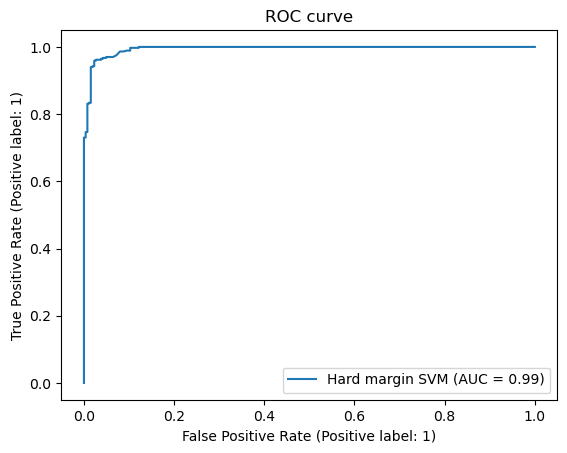

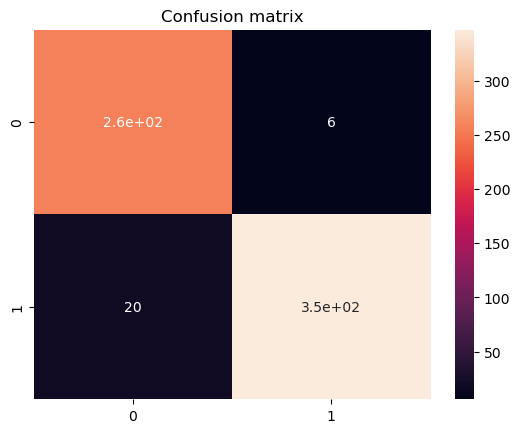

In [ ]:
from  sklearn.metrics import RocCurveDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
def evaluate_model(model, X_test, y_test, title):

  y_pred = model.predict(X_test)
  plt.figure()
  roc = RocCurveDisplay.from_estimator(model, X_test, y_test, name = title)
  plt.title('ROC curve')
  confusion = confusion_matrix(y_test,y_pred)
  acc = accuracy_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)

  print(f'Evaluation for {title} model')
  print('confusion matrix: ')
  plt.figure()
  sns.heatmap(confusion, annot=True)
  plt.title('Confusion matrix')
  #print(confusion)
  print('accuracy: ',acc)
  print('recall: ',recall)
  print('precision: ',precision)
  print('F1 score: ',f1)


from sklearn.svm import SVC
#Hard margin SVM
g = 1000
hard_svm = SVC(kernel='linear', C=g)
hard_svm.fit(X_tr_svd,Y_tr)
evaluate_model(hard_svm, X_ts_svd,Y_ts,'Hard margin SVM')

Evaluation for Soft margin SVM model
confusion matrix: 
accuracy:  0.5825396825396826
recall:  1.0
precision:  0.5825396825396826
F1 score:  0.7362086258776329


<Figure size 640x480 with 0 Axes>

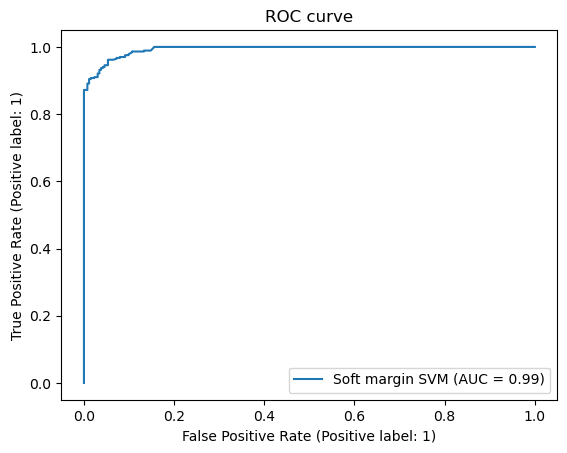

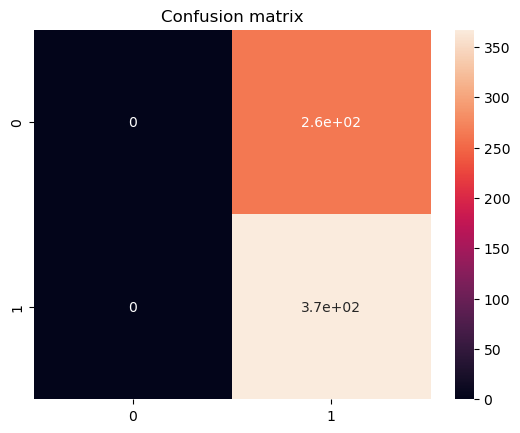

In [ ]:
#Soft margin SVM
g=0.0001
soft_svm = SVC(kernel='linear', C=g)
soft_svm.fit(X_tr_svd,Y_tr)
evaluate_model(soft_svm, X_ts_svd,Y_ts,'Soft margin SVM')

Evaluation for Hard margin SVM for C=100000 model
confusion matrix: 
accuracy:  0.9603174603174603
recall:  0.9482288828337875
precision:  0.9830508474576272
F1 score:  0.9653259361997226


<Figure size 640x480 with 0 Axes>

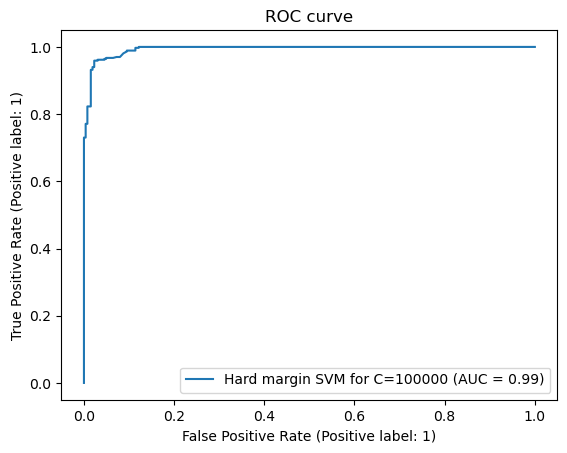

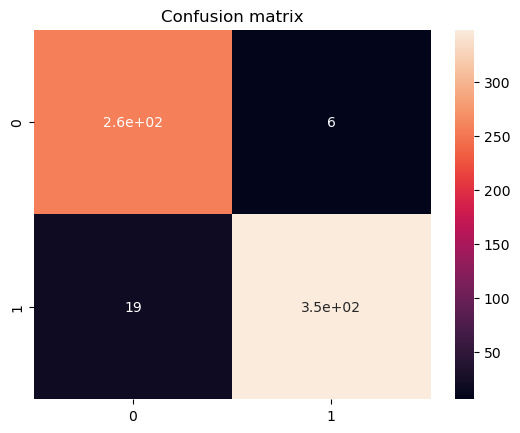

In [ ]:
#Very high value
g = 100000
hard_svm = SVC(kernel='linear', C=g)
hard_svm.fit(X_tr_svd,Y_tr)
evaluate_model(hard_svm, X_ts_svd,Y_ts,'Hard margin SVM for C=100000')

* Does the ROC curve reflect the performance of the soft-margin SVM? Why?<br>
  *One can observe that the ROC curve does NOT reflect the poor performance of the soft-margin model. One cannot use ROC curve when the data is highly unbalanced, which is the case here. This is because the false positive rate = ( false positive / total true negatives ) is not very sensitive to the number of false positives and does not drop significantly when the total true negatives is very large.*

* Use cross-validation to choose γ: 5-fold cross-validation.<br>
Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

In [ ]:
from sklearn.model_selection import cross_val_score
c = [10**i for i in range(-3,7,1)] #acceptable range for gamma
validation_acc = []
for C in c:
  print('working on C= ',C)
  svm = SVC(kernel='linear', C=C)
  scores = cross_val_score(svm, X_tr_svd, Y_tr, cv=5)
  validation_acc.append(scores.mean())

working on C=  0.001
working on C=  0.01
working on C=  0.1
working on C=  1
working on C=  10
working on C=  100
working on C=  1000
working on C=  10000
working on C=  100000
working on C=  1000000


Text(0.5, 1.0, 'Determining the best gamma value')

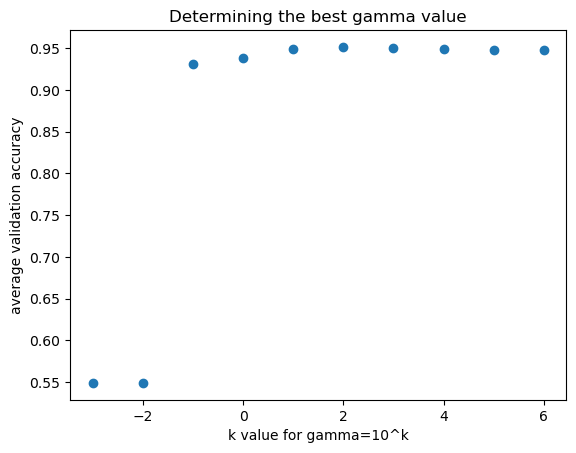

In [ ]:
plt.figure()
plt.scatter(range(-3,7,1),validation_acc)
plt.xlabel('k value for gamma=10^k')
plt.ylabel('average validation accuracy')
plt.title('Determining the best gamma value')

Best C value:  100
Evaluation for best SVM model
confusion matrix: 
accuracy:  0.9571428571428572
recall:  0.9427792915531336
precision:  0.9829545454545454
F1 score:  0.9624478442280947


<Figure size 640x480 with 0 Axes>

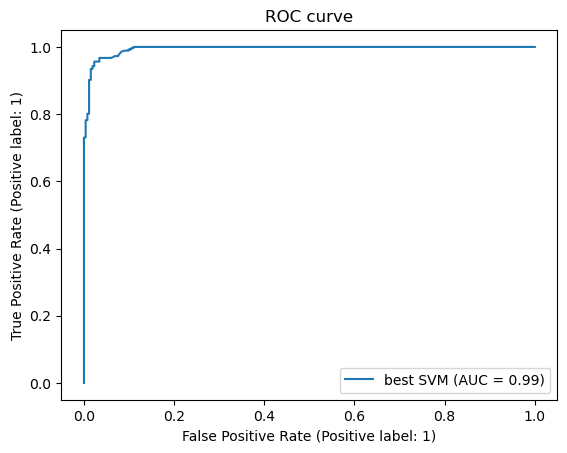

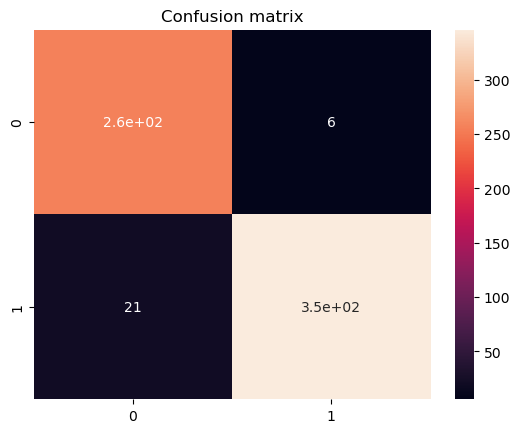

In [ ]:
best_idx = np.argmax(validation_acc)
best_c = c[best_idx]
print('Best C value: ',best_c)
svm_best = SVC(kernel='linear', C=best_c)
svm_best.fit(X_tr_svd,Y_tr)
evaluate_model(svm_best, X_ts_svd,Y_ts,'best SVM')

### Logistic Regression
QUESTION 6: Evaluate a logistic classifier:<br>
* Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
score of this classifier on the testing set.

Evaluation for Logistic Regression without regularization model
confusion matrix: 
accuracy:  0.9634920634920635
recall:  0.9509536784741145
precision:  0.9858757062146892
F1 score:  0.9680998613037448


<Figure size 640x480 with 0 Axes>

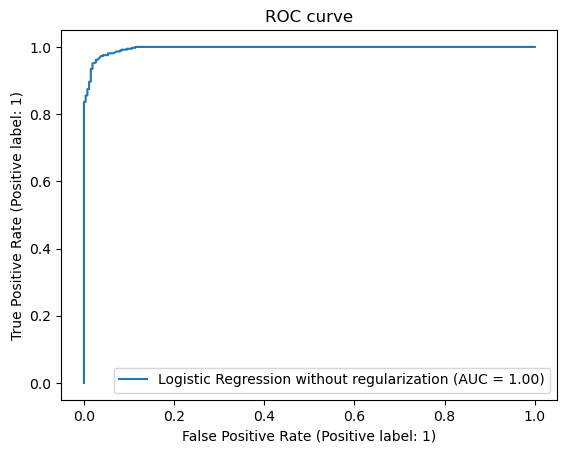

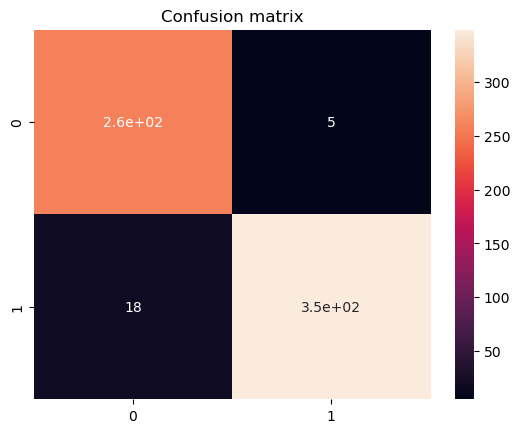

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty='none',solver='newton-cg')#penalty is set to None to disable regularization term
#NOTE: I had to change the solver because the default solver does not converge!
log_reg.fit(X_tr_svd,Y_tr)
evaluate_model(log_reg, X_ts_svd,Y_ts,'Logistic Regression without regularization')

* Find the optimal regularization coefficient:

– Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10^k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.<br>
  *Please see below for the implementations.*

– Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.<br>
  *The performance metrics for each model is reported through the evaluate_model() function. The models are not significantly different in terms of calculated metrics, however, each choice of regularization creates an implicit bias over the weights that are learned which we discuss in next question.*

– How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?<br>
  *Choice of regularization creates a type of bias for the weights the model converges to. For example, without regularization we might get very large values for the model weights which might not be reasonable for a problem at hand. L1 regularization imposes sparsity on the weights whereas L2 norm causes the weights to have small values. We can select the appropriate regularization based on the problem formulation and the characterisitcs (e.g. sparsity) we would like the model weights to have.*


– Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?<br>
  *One can observe that in terms of the metrics, linear SVM and Logistic Regression do not have significantly different performances. The differences between them are:* <br>
  *SVM is a deterministic algorithm that tries to maximize the distance (margin) between the line it fits and closest support vectors whereas Logistic Regression is a probabilistic algorithm that aims to maximize the conditional likelihood of the training data (posterior class probability) resulting in decision boundaries. Logistic Regression can only be used in classification problems while SVM can be used for both classification and regression. SVM is also less likely to overfit since Logistic Regression is sensitive to outliers.*

#### L1 Regularization

Best C for l1 regularization:  10
Evaluation for best Logistic Regression with l1 regularization model
confusion matrix: 
accuracy:  0.9634920634920635
recall:  0.9536784741144414
precision:  0.9831460674157303
F1 score:  0.9681881051175657


<Figure size 640x480 with 0 Axes>

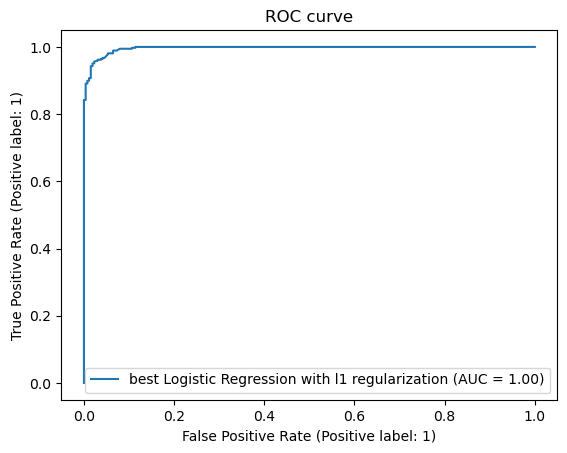

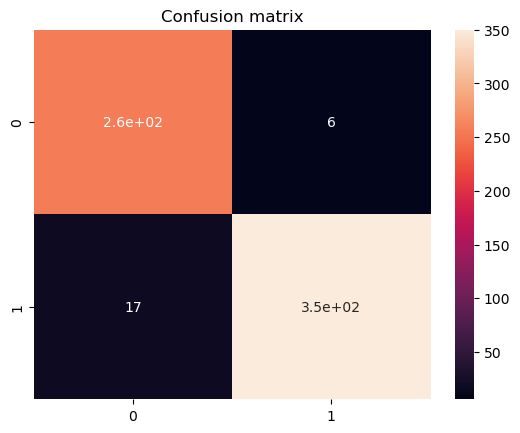

In [ ]:
c = [10**i for i in range(-5,6,1)] #acceptable range for gamma
validation_acc = []
for C in c:
  model = LogisticRegression(penalty='l1',C=C,solver='liblinear')
  scores = cross_val_score(model, X_tr_svd, Y_tr, cv=5)
  validation_acc.append(scores.mean())
best_idx = np.argmax(validation_acc)
best_l1_c = c[best_idx]
print('Best C for l1 regularization: ',best_l1_c)
l1_best = LogisticRegression(penalty='l1',C=best_l1_c,solver='liblinear')
l1_best.fit(X_tr_svd,Y_tr)
evaluate_model(l1_best, X_ts_svd,Y_ts,'best Logistic Regression with l1 regularization')

#### L2 Regularization

Best C for l2 regularization:  100
Evaluation for best Logistic Regression with l2 regularization model
confusion matrix: 
accuracy:  0.9650793650793651
recall:  0.9591280653950953
precision:  0.9805013927576601
F1 score:  0.9696969696969696


<Figure size 640x480 with 0 Axes>

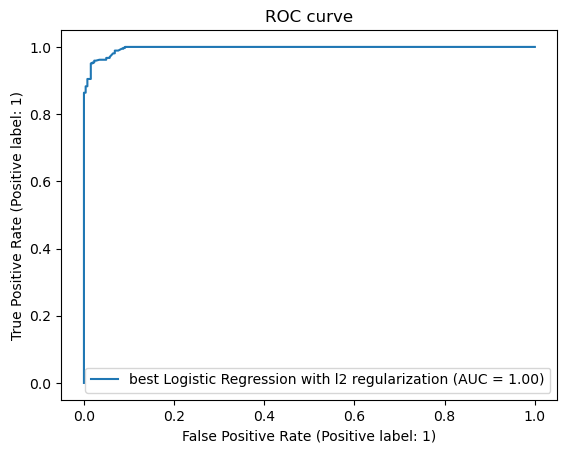

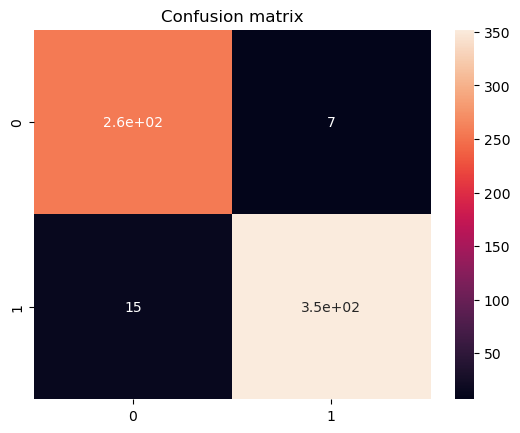

In [ ]:
c = [10**i for i in range(-5,6,1)] #acceptable range for gamma
validation_acc = []
for C in c:
  model = LogisticRegression(penalty='l2',C=C,solver='liblinear')
  scores = cross_val_score(model, X_tr_svd, Y_tr, cv=5)
  validation_acc.append(scores.mean())
best_idx = np.argmax(validation_acc)
best_l2_c = c[best_idx]
print('Best C for l2 regularization: ',best_l2_c)
l2_best = LogisticRegression(penalty='l2',C=best_l2_c,solver='liblinear')
l2_best.fit(X_tr_svd,Y_tr)
evaluate_model(l2_best, X_ts_svd,Y_ts,'best Logistic Regression with l2 regularization')

### Naive Bayes
QUESTION 7: Evaluate and profile a Naive Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Evaluation for Gaussian Naive Bayes model
confusion matrix: 
accuracy:  0.9428571428571428
recall:  0.9128065395095368
precision:  0.9882005899705014
F1 score:  0.9490084985835695


<Figure size 640x480 with 0 Axes>

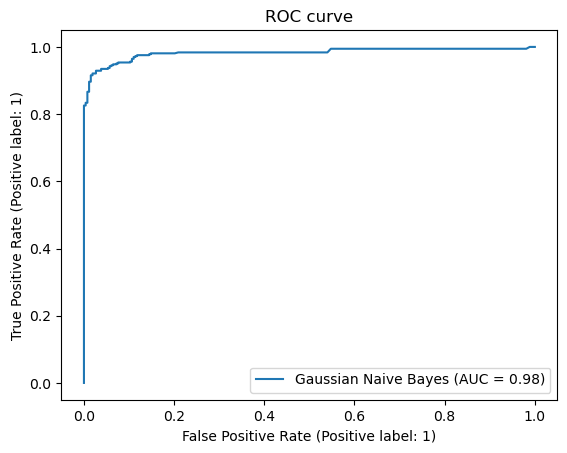

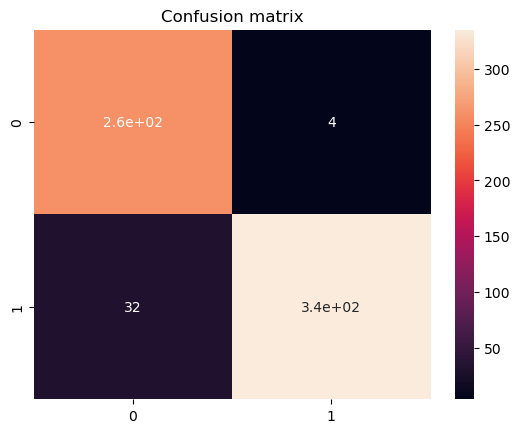

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_tr_svd,Y_tr)
evaluate_model(NB, X_ts_svd,Y_ts,'Gaussian Naive Bayes')

### Grid Search of Parameters

QUESTION 8: In this part, you will attempt to find the best model for binary classification.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

def clean_data(text):
    """
    This function is a combination of the given clean() function and remove_digit() that I defined previously.
    """
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter) 
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
      texter = ""
    texter = texter.lower() #converts to lower case
    texter = re.sub(r'\d+', '', text) #helps remove one or more (+) digits (\d) 
    return texter

from sklearn.base import BaseEstimator, TransformerMixin


class Dimension_reducer(BaseEstimator, TransformerMixin):

    def __init__(self, transformer = TruncatedSVD()):
        """
        We need to define this class to switch between dimensionality reduction algorithms
        """ 
        self.transformer = transformer

    def fit(self, X, y=None, **kwargs):
        self.transformer.fit(X, y)
        return self

    def transform(self, X, y=None, **kwargs):
        self.transformer.transform(X, y)
        return self

class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = GaussianNB()):
        """
        We need to define this class to switch between models
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)


params = {
    'Feature Extraction__min_df': [3,5], 'Feature Extraction__tokenizer': [lemm, stem], 'Feature Extraction__stop_words':[None], 'Feature Extraction__preprocessor':[clean_data],
    #'Dimensionality Reduction__transformer':[TruncatedSVD(),NMF(init='nndsvd',tol=0.01)],
    'Dimensionality Reduction':[TruncatedSVD(),NMF(init='nndsvd',tol=0.01)],
    'Dimensionality Reduction__n_components':[5,30,80], 
    'Classifier__estimator': [SVC(kernel='linear', C=10),
                   LogisticRegression(penalty='l1', C=10, solver='liblinear'),
                   LogisticRegression(penalty='l2', C=100, solver='liblinear'),
                   GaussianNB()
                   ]
}


#NOTE: I have combined the Loading Data section of the pipeline with Feature Extraction
pipe = Pipeline([
                 ('Feature Extraction', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),
                 ('Dimensionality Reduction',TruncatedSVD()),
                 ('Classifier',ClfSwitcher())
                ]) 


**NOTE:** Due to the high number of possible combinations and the limitations of my local machine, I have run Randomized search CV instead of Gridsearch CV (which is commented in the code)

In [ ]:
#print(pipe.get_params().keys())
#search = GridSearchCV(pipe, params, cv=5,scoring='accuracy', refit=True, verbose=2) #this took too long to run so I replaced it with RandomizedSearchCV
search = RandomizedSearchCV(pipe, params, cv=5,scoring='accuracy', n_iter = 20, refit=True)
search.fit(train['full_text'], Y_tr)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.957):
{'Feature Extraction__tokenizer': <function stem at 0x7f9c87b33ca0>, 'Feature Extraction__stop_words': None, 'Feature Extraction__preprocessor': <function clean_data at 0x7f9bb42d3f70>, 'Feature Extraction__min_df': 3, 'Dimensionality Reduction__n_components': 80, 'Dimensionality Reduction': TruncatedSVD(n_components=80), 'Classifier__estimator': LogisticRegression(C=10, penalty='l1', solver='liblinear')}


* What are the 5 best combinations? Report their performances on the testing set.<br>
 *Please see below for the top 5 ranked parameter combinations.*

In [ ]:
result = search.cv_results_
df = pd.DataFrame(data={'params': result['params'], 'mean_test_score': result['mean_test_score']})
df = df.sort_values(by=['mean_test_score'], ascending=False)
print('Evaluation of top 5 parameters set: ')
print('Parameters, mean test score:')
for i in range(5):
  print(df.iloc[i]['params'],df.iloc[i]['mean_test_score'])
  model = pipe.set_params(**df.iloc[i]['params'])
  model.fit(train['full_text'], Y_tr)
  acc = model.score(test['full_text'],Y_ts)
  print(f'Model rank {i+1} has accuracy {acc}')
  


Evaluation of top 5 parameters set: 
Parameters, mean test score:
{'Feature Extraction__tokenizer': <function stem at 0x7f9c87b33ca0>, 'Feature Extraction__stop_words': None, 'Feature Extraction__preprocessor': <function clean_data at 0x7f9bb42d3f70>, 'Feature Extraction__min_df': 3, 'Dimensionality Reduction__n_components': 80, 'Dimensionality Reduction': TruncatedSVD(n_components=80), 'Classifier__estimator': LogisticRegression(C=10, penalty='l1', solver='liblinear')} 0.9571428571428571
Model rank 1 has accuracy 0.9714285714285714
{'Feature Extraction__tokenizer': <function lemm at 0x7f9c87b33b80>, 'Feature Extraction__stop_words': None, 'Feature Extraction__preprocessor': <function clean_data at 0x7f9bb42d3f70>, 'Feature Extraction__min_df': 3, 'Dimensionality Reduction__n_components': 80, 'Dimensionality Reduction': TruncatedSVD(n_components=80), 'Classifier__estimator': LogisticRegression(C=100, solver='liblinear')} 0.9492063492063492
Model rank 2 has accuracy 0.9634920634920635
{

## Multiclass Classification

QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.<br>
Perform Naıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?<br>
 *The 9 classes are balanced based on the histograms we plotted earlier so I did not need to use any strategies. However, in case of imbalanced data we can either undersample larger classes or resample smaller classes (to have more samples, redundant ofcourse)*

In [ ]:
#replace categorical labels with numbers
from sklearn.pipeline import Pipeline
map_row_to_class = {"chess":0, "cricket":1, "hockey":2, "soccer":3,
"football":4, "%22forest%20fire%22":5, "flood":6, "earthquake":7,
"drought":8}
df = pd.read_csv(PATH)
display(df)

train, test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

X_tr = train['full_text'].apply(clean)
X_ts = test['full_text'].apply(clean)

pipe = Pipeline([('count', CountVectorizer(min_df=3,stop_words={'english'}, #count words by:
                        preprocessor=remove_digit,tokenizer=lemm)), #removing digits and lemmatizing
                        ('tfid', TfidfTransformer())]) #finally apply TF-IDF
X_tr_new = pipe.fit_transform(X_tr).toarray()
X_ts_new = pipe.transform(X_ts).toarray()


U, S, V_h = np.linalg.svd(X_tr_new, full_matrices=False)
V = V_h.T
k=50
V_k = V[:,:k]

X_tr = X_tr_new@V_k
X_ts = X_ts_new@V_k

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports
...,...,...,...,...,...,...,...,...
3145,'By Rachel Premack of FreightWaves\n\nYou prob...,'Right now the barge industry — and all of us ...,"['coal', 'traffic', 'right', 'mississippi', 's...",NaN,['Tyler Durden'],https://www.zerohedge.com/markets/latest-suppl...,drought,climate
3146,'Manufacturing had a big summer. The CHIPS and...,'To address these issues and drive the transit...,"['manufacturing', 'system', 'future', 'technol...",NaN,['Mary Beth Gallagher'],https://news.mit.edu/2022/manufacturing-cleane...,drought,climate
3147,"'A golf cart on a path at Verrado, an 8,800-ac...",'Water flow has dropped precipitously in the C...,"['developers', 'live', 'state', 'development',...",NaN,['Keith Schneider'],https://news.yahoo.com/thousands-live-one-day-...,drought,climate
3148,"'Jakarta, Dec 25 (EFE).- Dozens of Rohingya re...","'Jakarta, Dec 25 (EFE).- Dozens of Rohingya re...","['rohingyas', 'told', 'indonesia', 'refugees',...",NaN,['Online News Editor'],https://www.laprensalatina.com/dozens-of-rohin...,drought,climate


In [ ]:
Y_tr = train.replace({'leaf_label':map_row_to_class}, inplace=False)['leaf_label']
Y_ts = test.replace({'leaf_label':map_row_to_class}, inplace=False)['leaf_label']

print('train data shape: ',X_tr.shape, Y_tr.shape)
print('test data shape: ',X_ts.shape, Y_ts.shape)

train data shape:  (2520, 50) (2520,)
test data shape:  (630, 50) (630,)


In [ ]:
import seaborn as sns

def evaluate_multiclass_model(model,X_test,y_test,title):

  y_pred = model.predict(X_test)
  confusion = confusion_matrix(y_test,y_pred)
  acc = accuracy_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred,average='micro')
  precision = precision_score(y_test,y_pred,average='micro')
  f1 = f1_score(y_test,y_pred,average='micro')

  print(f'Evaluation for {title} model')
  #print('confusion matrix: ')
  plt.figure()
  sns.heatmap(confusion, annot=True)
  plt.title('Confusion matrix')
  #print(confusion)
  print('accuracy: ',acc)
  print('recall: ',recall)
  print('precision: ',precision)
  print('F1 score: ',f1)

### One vs Rest

Evaluation for OVR SVM model
accuracy:  0.780952380952381
recall:  0.780952380952381
precision:  0.780952380952381
F1 score:  0.780952380952381


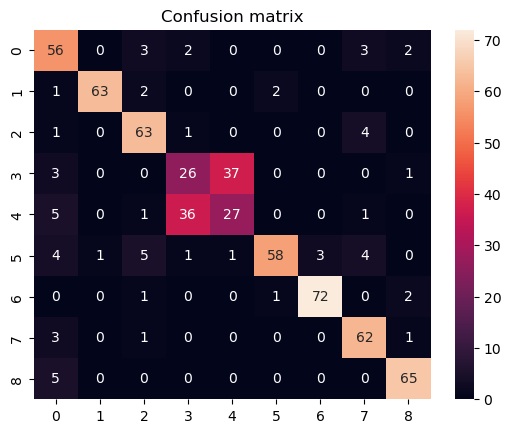

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
model_SVM = OneVsRestClassifier(SVC(kernel='linear', C=10)).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVR SVM')

Evaluation for OVR Naive Bayes model
accuracy:  0.7444444444444445
recall:  0.7444444444444445
precision:  0.7444444444444445
F1 score:  0.7444444444444445


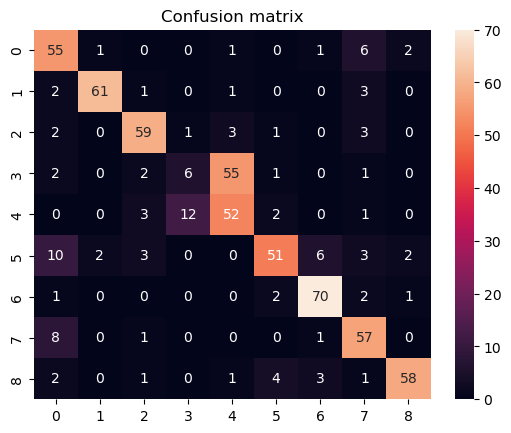

In [ ]:
from sklearn.naive_bayes import GaussianNB
model_NB = OneVsRestClassifier(GaussianNB()).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVR Naive Bayes')

### One vs One

Evaluation for OVO SVM model
accuracy:  0.7841269841269841
recall:  0.7841269841269841
precision:  0.7841269841269841
F1 score:  0.7841269841269841


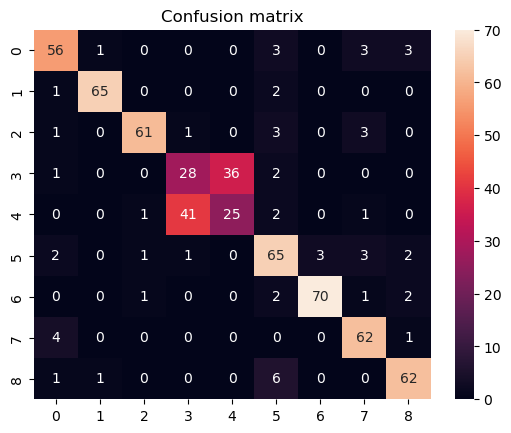

In [ ]:
model_SVM = OneVsOneClassifier(SVC(kernel='linear', C=10)).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVO SVM')

Evaluation for OVO Naive Bayes model
accuracy:  0.7412698412698413
recall:  0.7412698412698413
precision:  0.7412698412698413
F1 score:  0.7412698412698413


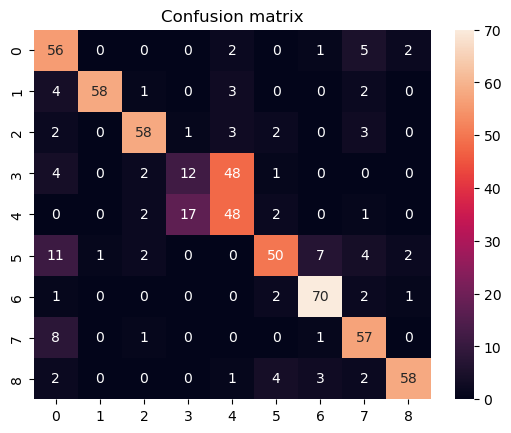

In [ ]:
model_NB = OneVsOneClassifier(GaussianNB()).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVO Naive Bayes')

* Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean? <br>
 *If we take a look at confusion matrices, we notice that there exist some smaller blocks. This implies that the data from some classes are less distinguishabe compared to other classes and they get mislabeled more often.*<br>
 *For both SVM and NB, labels 3 and 4 can form a single block.* 

* Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?<br>
  *Based on my observations, I suggect combining labels 3,4 together. In this case, label imbalance is created which could be problematic. Please note that the heatmaps for confusion matrix automatically labels from 0-7. From 0-3 the labels match the guide provided in PDF file but 4-7 actually correspond to labels 5-8. Let's see the results:*

In [ ]:
new_map = {"chess":0, "cricket":1, "hockey":2, "soccer":3,
"football":3, "%22forest%20fire%22":5, "flood":6, "earthquake":7,
"drought":8}
Y_tr = train.replace({'leaf_label':new_map}, inplace=False)['leaf_label']
Y_ts = test.replace({'leaf_label':new_map}, inplace=False)['leaf_label']

### One vs Rest

Evaluation for OVR SVM model
accuracy:  0.9047619047619048
recall:  0.9047619047619048
precision:  0.9047619047619048
F1 score:  0.9047619047619048


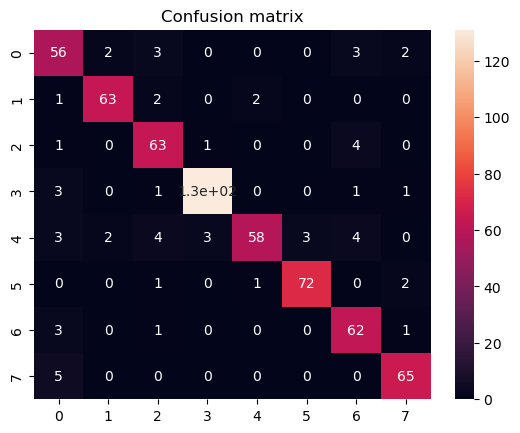

In [ ]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
model_SVM = OneVsRestClassifier(SVC(kernel='linear', C=10)).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVR SVM')

Evaluation for OVR Naive Bayes model
accuracy:  0.834920634920635
recall:  0.834920634920635
precision:  0.834920634920635
F1 score:  0.834920634920635


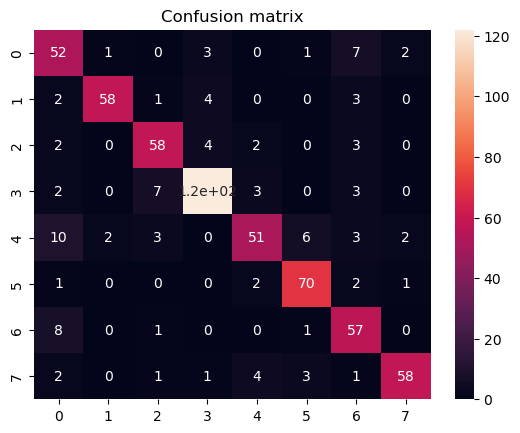

In [ ]:
model_NB = OneVsRestClassifier(GaussianNB()).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVR Naive Bayes')

### One vs One

Evaluation for OVO SVM model
accuracy:  0.9031746031746032
recall:  0.9031746031746032
precision:  0.9031746031746032
F1 score:  0.9031746031746032


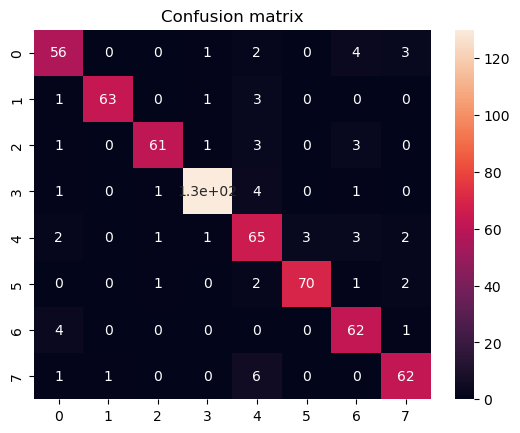

In [ ]:
model_SVM = OneVsOneClassifier(SVC(kernel='linear', C=10)).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVO SVM')

Evaluation for OVO Naive Bayes model
accuracy:  0.8396825396825397
recall:  0.8396825396825397
precision:  0.8396825396825397
F1 score:  0.8396825396825398


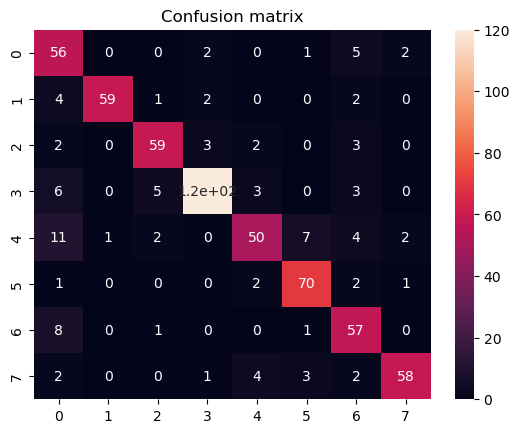

In [ ]:
model_NB = OneVsOneClassifier(GaussianNB()).fit(X_tr, Y_tr)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVO Naive Bayes')

 *In both types of evaluation, we see significant improvement in all evaluated metrics. Now we address the sample imbalance issue with One vs Rest evaluation to see if we can improve.*

* Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.<br>
 *In order to address this issue I tried both undersampling techniques called NearMiss and RandomUnderSampler However, surprisingly I did not see an improvement on the performance.*

In [ ]:
#!pip install imblearn
#!pip install daal4py
from imblearn.under_sampling import NearMiss, RandomUnderSampler
nm = RandomUnderSampler()
X_res, Y_res = nm.fit_resample(X_tr, Y_tr)

### OVR after addressing label imbalance

Evaluation for OVR SVM model
accuracy:  0.9095238095238095
recall:  0.9095238095238095
precision:  0.9095238095238095
F1 score:  0.9095238095238095


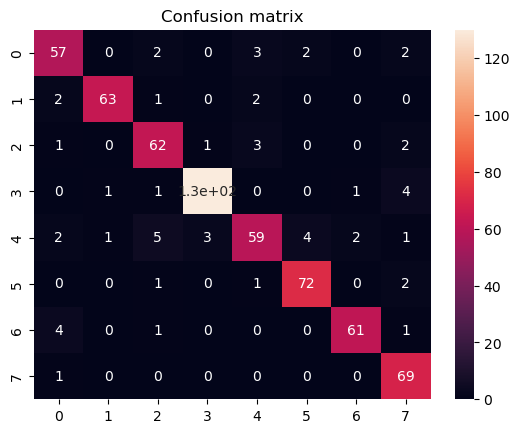

In [ ]:
model_SVM = OneVsRestClassifier(SVC(kernel='linear', C=10)).fit(X_res, Y_res)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVR SVM')

Evaluation for OVR Naive Bayes model
accuracy:  0.8365079365079365
recall:  0.8365079365079365
precision:  0.8365079365079365
F1 score:  0.8365079365079365


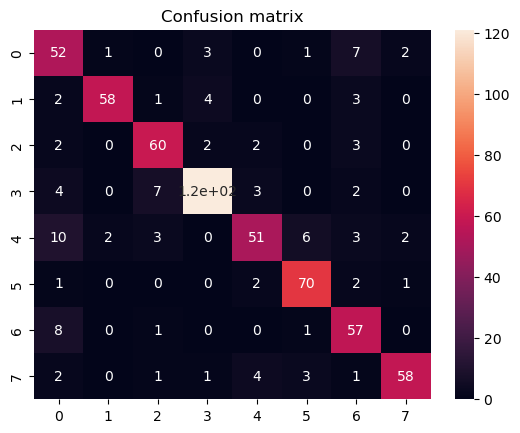

In [ ]:
model_NB = OneVsRestClassifier(GaussianNB()).fit(X_res, Y_res)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVR Naive Bayes')

### OVO after addressing label imbalance

Evaluation for OVO SVM model
accuracy:  0.9015873015873016
recall:  0.9015873015873016
precision:  0.9015873015873016
F1 score:  0.9015873015873016


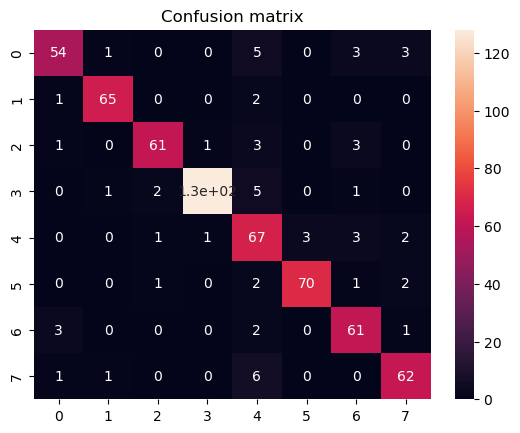

In [ ]:
model_SVM = OneVsOneClassifier(SVC(kernel='linear', C=10)).fit(X_res, Y_res)
evaluate_multiclass_model(model_SVM, X_ts,Y_ts,'OVO SVM')

Evaluation for OVO Naive Bayes model
accuracy:  0.834920634920635
recall:  0.834920634920635
precision:  0.834920634920635
F1 score:  0.834920634920635


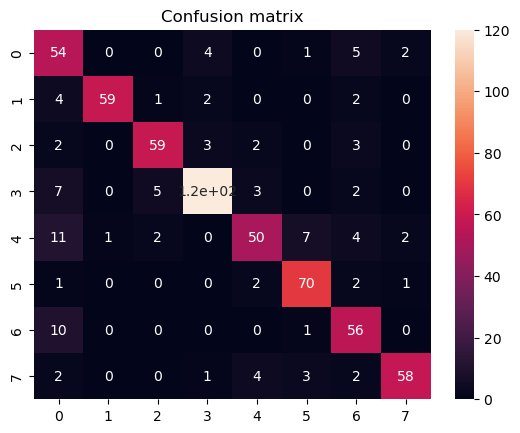

In [ ]:
model_NB = OneVsOneClassifier(GaussianNB()).fit(X_res, Y_res)
evaluate_multiclass_model(model_NB, X_ts,Y_ts,'OVO Naive Bayes')

## Word Embedding

QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:<br>
(a) Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than the probabilities themselves?<br>
 *Let's assume two words "king" denoted by i and "queen" denoted by j. Now any other word, denoted by k can be analyzed as follows: E.g k="man" is more relevant to i so P_{ik}/P_{jk} should be larger. For k="woman" that ratio should be smaller. But for an irrelevant word such as k="orange" or a word that is equally relevant such as k="monarchy", the ratio will be close to 1. I.e., quote: compared to the raw probabilities, the ratio can better distinguish relevant words (king and queen) from irrelevant words (orange) and can also better discriminate between the two relevant words.*




(b) In the two sentences: “James is running in the park.” and “James is running for the presidency.”, would GLoVE embeddings return the same vector for the word running in both cases? Why or why not? <br>
 *Unlike BoW, GLoVE takes into account the context a word appears in. As mentioned earlier, we work with ratio of co-occurance probabilities, so it is expected that due to different contexts the word "running" appears in and hence the different meanings, the returned vectors should be different.*


In [ ]:
def create_embedding(dimension_of_glove=300):

    embeddings_dict = {}
    GLOVE_PATH = f'glove.6B.{dimension_of_glove}d.txt'#'/content/drive/MyDrive/UCLA Courses/219/glove.6B.300d.txt'
    with open(GLOVE_PATH, 'r') as f: 
      for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
        
    return embeddings_dict

dimension_of_glove=300
embeddings_dict = create_embedding(dimension_of_glove)

(c) What do you expect for the values of,<br>
c1 = ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||_2,
c2 = ||GLoVE["queen"] - GLoVE["king"]||_2 and c3 = ||GLoVE["wife"] - GLoVE["husband"]||_2 ?

Compare these values.<br>
*I expect to have c2 - c3 <= c1 <= c2 + c3 based on triangle inequality. See below for the computations. Interestingly, I expected c2 and c3 to be closer together and c1 to be close to 0 but this is not true in practice, instead c1 and c2 are very close. It seems that with GLoVE, husband and wife vectors are not considered very different.*

In [ ]:
c1 = embeddings_dict['queen']-embeddings_dict['king']-embeddings_dict['wife']+embeddings_dict['husband']
c2 = embeddings_dict['queen']-embeddings_dict['king']
c3 = embeddings_dict['wife']-embeddings_dict['husband']

print('c1 = ',np.linalg.norm(c1,ord=2))
print('c2 = ',np.linalg.norm(c2,ord=2))
print('c3 = ',np.linalg.norm(c3,ord=2))

c1 =  6.1650367
c2 =  5.966258
c3 =  3.1520464


(d) Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE embedding? <br>
 *Stemming is useful when the vocabulary space is small and the documents are large. In practice, lemmatization is not very useful when using embeddings such as GLoVE. Using lemmatization, the gain from better performance does not outweigh the added computational cost. So based on these, I will most probably choose to work with stemming.*

QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class: <br>
(a) Describe a feature engineering process that uses GLoVE word embeddings to represent each document.<br>
*Based on the given hint, I decided to use "keywords" as raw features. Then, while ignoring words that are not in the GLoVE embedding, I converted each word to GLoVE representation of it and returned the average of vector representations of all keywords in each text as the final feature to be used in the model.*

In [ ]:
def embedd(dictionary,text,dim):
  """
  for a given list of words, each word are converted to their GLoVE vectors and the average of vectors is returned
  """
  #print(text)
  #print(type(text))
  vec = np.zeros((1,dim))
  n = 0
  text = str(text).strip('[]').replace("'", '').replace(' ', '').split(',')
  for item in text:
    if item in dictionary:
        n = n+1
        vec = vec + dictionary[item].reshape(1,dim)
  return np.array((vec/n)[0])

def convert_data(df,dictionary,dim):
    N = df.shape[0]
    new_df = pd.DataFrame(columns = list(range(dim)),index = list(range(N)))
    for idx in range(N):
        new_df.iloc[idx] = embedd(dictionary,df.iloc[idx],dim)
    return new_df
        

In [ ]:
#clean text with given code
df = pd.read_csv(PATH)
train, test = train_test_split(df[["keywords","root_label"]], test_size=0.2)
X_tr = convert_data(train['keywords'],embeddings_dict,dimension_of_glove)
X_ts = convert_data(test['keywords'],embeddings_dict,dimension_of_glove)

#read labels and convert them to binary
encoder = LabelEncoder()
Y_tr = encoder.fit_transform(train['root_label'])
Y_ts = encoder.transform(test['root_label'])
print('Binary labels are assigned as follows: ')
print('0: ',encoder.inverse_transform([0]))
print('1: ',encoder.inverse_transform([1]))


Binary labels are assigned as follows: 
0:  ['climate']
1:  ['sports']


In [ ]:
print('train data shape: ',X_tr.shape)
print('test data shape: ',X_ts.shape)

train data shape:  (2520, 300)
test data shape:  (630, 300)


(b) Select a classifier model, train and evaluate it with your GLoVE-based feature. <br>
*First I reduce the dimensionality of feature vectors using SVD and then I train a Logistic Regression on it.*

Evaluation for Logistic Regression model
accuracy:  0.9492063492063492
recall:  0.9492063492063492
precision:  0.9492063492063492
F1 score:  0.9492063492063492


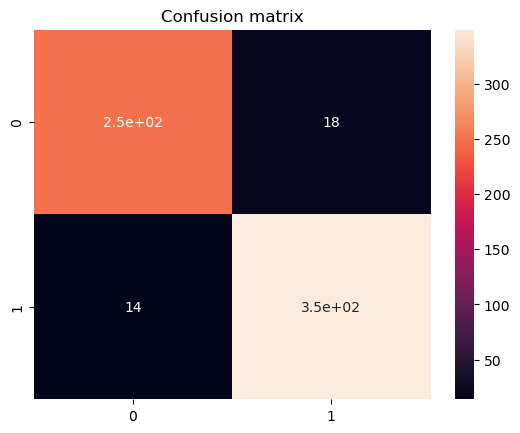

In [ ]:
preprocessor = TruncatedSVD(n_components = 80)
X_train = preprocessor.fit_transform(X_tr)
X_test = preprocessor.transform(X_ts)
model = LogisticRegression()
model.fit(X_train,Y_tr)
evaluate_multiclass_model(model, X_test, Y_ts,'Logistic Regression')

QUESTION 12: Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the link.<br>
*The figure below shows that by increasing the GLoVE dimensionality from 50 to 300, we first see a slight decrease in accuracy (when dimension changes from 100 to 200) but then as dimensionality increases, the accuracy increases as well. One can argue that this increase is due to having access to more information on embedded words by representing them with higher dimensional vectors.*

vector dimensions:  50
vector dimensions:  100
vector dimensions:  200
vector dimensions:  300


Text(0.5, 1.0, 'Evaluating effect of GLoVE embedding dimensionality on final model accuracy')

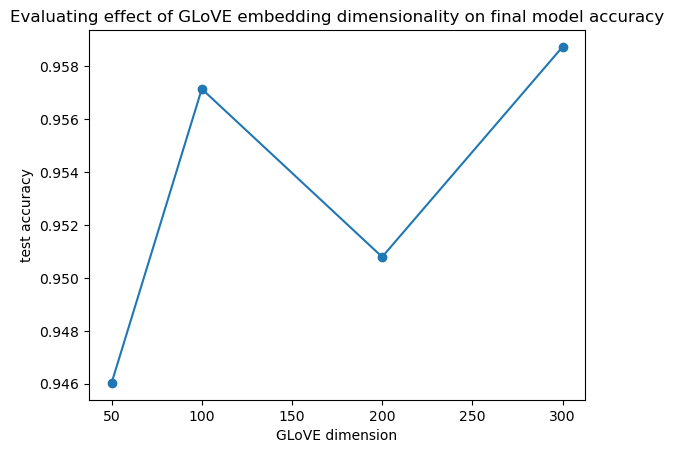

In [ ]:
dimensions = [50,100,200,300]
accuracies = []
for dim in dimensions:
    embeddings_dict = create_embedding(dim)
    X_tr = convert_data(train['keywords'],embeddings_dict,dim)
    X_ts = convert_data(test['keywords'],embeddings_dict,dim)
    
    print('vector dimensions: ',X_tr.shape[1])
    #preprocessor = TruncatedSVD(n_components = 40)
    #X_train = preprocessor.fit_transform(X_tr)
    #X_test = preprocessor.transform(X_ts)
    model = LogisticRegression()
    model.fit(X_tr,Y_tr)
    acc = model.score(X_ts,Y_ts)
    accuracies.append(acc)
    
plt.figure()
plt.plot(dimensions,accuracies,marker='o')
plt.xlabel('GLoVE dimension')
plt.ylabel('test accuracy')
plt.title('Evaluating effect of GLoVE embedding dimensionality on final model accuracy')

Visualize the set of normalized GLoVE-based embeddings of the documents with their binary labels in a 2D plane using the UMAP library. Similarly generate a set of normalized random vectors of the same dimension as GLoVE and visualize these in a 2D plane with UMAP.<br>

In [ ]:
!pip uninstall umap --y
!pip install umap-learn 



Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Successfully uninstalled umap-0.1.1


In [ ]:
#!pip install daal==2021.4.0
#!pip install 'numpy<1.23.0,>=1.16.5'

import umap.umap_ as umap
reducer = umap.UMAP()

df_train = X_tr.copy()
df_train[dim] = Y_tr.tolist()
#display(df_train)
df_test = X_ts.copy()
df_test[dim] = Y_ts.tolist()

embedding_train = reducer.fit_transform(df_train)
embedding_test = reducer.transform(df_test)


#Dataframe of random vectors
rand_v = np.random.normal(0,10,(100,dim))
rand_v = rand_v/np.linalg.norm(rand_v)
rand_y = np.ones((100,1))
rand_data = np.column_stack((rand_v,rand_y))
embedding_rand = reducer.transform(rand_data)

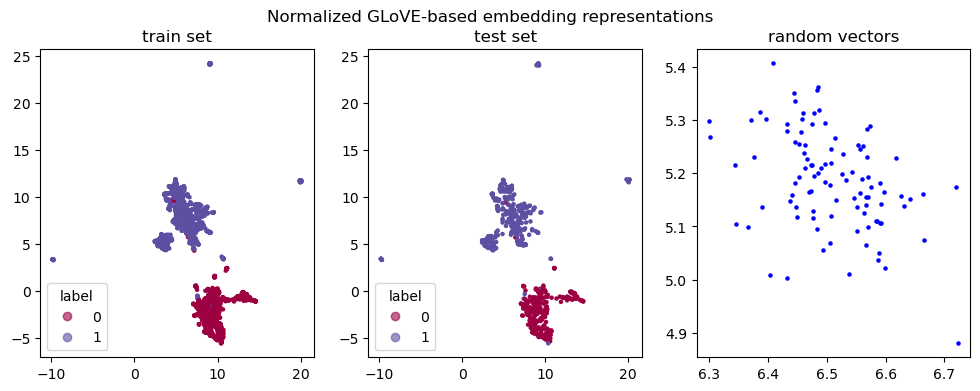

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4))
sc1 =ax1.scatter(embedding_train[:, 0], embedding_train[:, 1], c=Y_tr, cmap='Spectral', s=5)
ax1.set_title('train set')
handles, labels = sc1.legend_elements(prop="colors", alpha=0.6)
leg1 = ax1.legend(handles, labels, loc="lower left", title="label")

sc2 =ax2.scatter(embedding_test[:, 0], embedding_test[:, 1], c=Y_ts, cmap='Spectral', s=5)
ax2.set_title('test set')
handles, labels = sc2.legend_elements(prop="colors", alpha=0.6)
leg2 = ax2.legend(handles, labels, loc="lower left", title="label")

sc3 = ax3.scatter(embedding_rand[:, 0], embedding_rand[:, 1], c='b', s=5)
ax3.set_title('random vectors')

fig.suptitle('Normalized GLoVE-based embedding representations')
plt.show()


QUESTION 13: Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project. <br>
*For representations of both train and test sets we see two distinctive clusters. In contrast, the random vectors do not seem to form clusters (as expected).* 